# Implémentation UNet

## Importation des bibliothèques

In [ ]:
# === Base Python ===
import os
import glob
import random
from pathlib import Path

# === Typage ===
from typing import Optional, Union, Tuple

# === NumPy / Pandas / Math / Visualisation ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

# === PIL (images) ===
from PIL import Image

# === PyTorch / Torchvision ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torchvision
from torchvision import transforms

# === Monai (medical imaging) ===
import monai
from monai.transforms import LoadImage
from monai.losses import DiceLoss

# === Affichage modèle ===
from torchinfo import summary

# === Barre de progression ===
from tqdm.auto import tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

Using device: cuda
2.5.1
12.4
True


## Load PNG Data

In [3]:
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import os
import re
from pathlib import Path

class PngSlicesDataset(Dataset):
    def __init__(self, root_dir, resized_width=256, resized_height=256, slice_range=None, transform=None):
        self.image_paths = []
        self.mask_paths = []
        self.patient_names = []  # Nouvelle liste parallèle
        self.resized_width = resized_width
        self.resized_height = resized_height
        self.slice_range = slice_range
        self.transform = transform if transform is not None else transforms.ToTensor()

        patients = sorted(os.listdir(root_dir))
        for patient in patients:
            images_folder = os.path.join(root_dir, patient, "IRM")
            masks_folder = os.path.join(root_dir, patient, "masque")

            if not os.path.isdir(images_folder) or not os.path.isdir(masks_folder):
                continue

            image_files = sorted(os.listdir(images_folder))
            for img_file in image_files:
                # Utiliser une expression régulière pour détecter slice_XXXX.png
                match = re.match(r"slice_(\d+)\.png", img_file)
                if not match:
                    continue

                slice_num = int(match.group(1))

                if self.slice_range:
                    if not (self.slice_range[0] <= slice_num <= self.slice_range[1]):
                        continue

                img_path = os.path.join(images_folder, img_file)
                mask_path = os.path.join(masks_folder, img_file)

                if os.path.exists(img_path) and os.path.exists(mask_path):
                    self.image_paths.append(img_path)
                    self.mask_paths.append(mask_path)
                    self.patient_names.append(patient)  # Stocker le nom du patient

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('L')
        mask = Image.open(self.mask_paths[idx]).convert('L')

        resize_transform = transforms.Resize((self.resized_height, self.resized_width))

        img = resize_transform(img)
        mask = resize_transform(mask)

        img = self.transform(img)
        mask = self.transform(mask)
        #print("Valeurs image :", torch.min(img).item(), torch.max(img).item())  # <-- ICI ✅
        img = (img - 0.5) / 0.5  # Normaliser [-1,1]
        mask = (mask > 0.5).float()  # Binariser

        return img, mask, os.path.basename(self.image_paths[idx])

    def get_patient_name(self, idx):
        return self.patient_names[idx]


## Define train, test, validation dataset

### Here we get the initial image shapes

This value is important, as it will allow us to resize our entire dataset. We must also bear in mind that the size **must be a multiple of two**. This is because, through downsampling (by a factor of two), **we want natural numbers**. 

In [4]:
from PIL import Image
import os

def GetInitialImageShape(images_folder): 
    image_files = sorted([f for f in os.listdir(images_folder) if f.endswith('.png')])
    img = Image.open(os.path.join(images_folder, image_files[0]))
    w, h = img.size
    return (w,h)

def getNearestMultipleOfTwo(x):
    multipleOfTwo = [2**i for i in range(10)]
    mini = float('inf')
    nearest_value = None
    
    for elem in multipleOfTwo:
        difference = abs(elem - x)
        if difference < mini:
            mini = difference
            nearest_value = elem
    
    return nearest_value

Here we define `width` and `height` of our __dataset__ et autres constantes

In [44]:
w,h = GetInitialImageShape("./UNet_data_png/01016SACH/IRM")
width = getNearestMultipleOfTwo(w)
height = getNearestMultipleOfTwo(h)
slice_range = [145, 291]
LEARNING_RATE = 3e-4
BATCH_SIZE = 8
learning_rate = 0.001
n_epochs = 60
ROOT_DIR = './UNet_data_png'

In [32]:
import random
from pathlib import Path
from torch.utils.data import Subset

# === Création du dataset complet ===
dataset = PngSlicesDataset(
    root_dir=ROOT_DIR,
    resized_width=width,
    resized_height=height,
    slice_range=slice_range
)

# === Sélection aléatoire de patients ===
all_patients = sorted(list({dataset.get_patient_name(i) for i in range(len(dataset))}))
assert len(all_patients) >= 15, "Il faut au moins 15 patients."

random.seed(42)
random.shuffle(all_patients)

train_patients = all_patients[:9]
val_patients = all_patients[9:12]
test_patients = all_patients[12:15]

# === Fonction pour récupérer les indices filtrés ===
def get_balanced_indices(dataset, patient_list, max_vide_ratio=0.2):
    lesion_indices = []
    empty_indices = []

    for idx in range(len(dataset)):
        patient = dataset.get_patient_name(idx)
        if patient in patient_list:
            _, mask, _ = dataset[idx]
            if mask.sum().item() > 0:
                lesion_indices.append(idx)
            else:
                empty_indices.append(idx)

    # Limiter les slices vides
    max_empty = int(len(lesion_indices) * max_vide_ratio)
    empty_indices = empty_indices[:max_empty]

    final_indices = lesion_indices + empty_indices
    random.shuffle(final_indices)
    return final_indices

# === Obtenir les indices équilibrés par split ===
train_idx = get_balanced_indices(dataset, train_patients, max_vide_ratio=0.2)
val_idx   = get_balanced_indices(dataset, val_patients, max_vide_ratio=0.2)
test_idx  = get_balanced_indices(dataset, test_patients, max_vide_ratio=0.2)

# === Créer les subsets PyTorch ===
train_dataset = Subset(dataset, train_idx)
val_dataset   = Subset(dataset, val_idx)
test_dataset  = Subset(dataset, test_idx)


### Data loader + his test


In [34]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset,batch_size=BATCH_SIZE,shuffle= False)
test_dataloader = DataLoader(dataset=test_dataset,batch_size=1, shuffle=False)

### Test proportion empty mask

In [27]:
def analyse_masques_vides_par_patient(dataset, indices=None):
    from collections import defaultdict

    vide_par_patient = defaultdict(lambda: {"total": 0, "vides": 0})

    if indices is None:
        indices = range(len(dataset))

    for idx in indices:
        if isinstance(dataset, torch.utils.data.Subset):
            vrai_idx = dataset.indices[idx]
            patient = dataset.dataset.get_patient_name(vrai_idx)
            _, mask, _ = dataset.dataset[vrai_idx]
        else:
            patient = dataset.get_patient_name(idx)
            _, mask, _ = dataset[idx]

        vide_par_patient[patient]["total"] += 1
        if mask.sum().item() == 0:
            vide_par_patient[patient]["vides"] += 1

    print(f"{'Patient':<15}{'Slices vides':<15}{'Total slices':<15}{'Proportion vide'}")
    print("-" * 60)
    for patient, stats in sorted(vide_par_patient.items()):
        total = stats["total"]
        vides = stats["vides"]
        proportion = vides / total if total > 0 else 0
        print(f"{patient:<15}{vides:<15}{total:<15}{proportion:.2%}")


In [35]:
# Analyse sur tout le dataset
analyse_masques_vides_par_patient(dataset)

# Analyse sur les sous-ensembles
analyse_masques_vides_par_patient(train_dataset)
analyse_masques_vides_par_patient(val_dataset)
analyse_masques_vides_par_patient(test_dataset)

Patient        Slices vides   Total slices   Proportion vide
------------------------------------------------------------
01016SACH      17             147            11.56%
01038PAGU      17             147            11.56%
01039VITE      23             147            15.65%
01040VANE      110            147            74.83%
01042GULE      54             147            36.73%
07001MOEL      64             147            43.54%
07003SATH      19             147            12.93%
07010NABO      80             147            54.42%
07040DORE      58             147            39.46%
07043SEME      57             147            38.78%
08002CHJE      30             147            20.41%
08027SYBR      66             147            44.90%
08029IVDI      31             147            21.09%
08031SEVE      46             147            31.29%
08037ROGU      3              147            2.04%
Patient        Slices vides   Total slices   Proportion vide
--------------------------------------

In [36]:
# Vérification du DataLoader
for img, mask, path in  test_dataloader:
    print(f'Image batch shape: {img.shape}')
    print(f'Mask batch shape: {mask.shape}')
    print(f'Image path: {path[0]}')  # Afficher un chemin d'image pour vérifier
    break  # Juste pour vérifier une première itération

Image batch shape: torch.Size([1, 1, 256, 256])
Mask batch shape: torch.Size([1, 1, 256, 256])
Image path: slice_227.png


## Visualize data samples

train_idx: 509
val_idx: 28
test_idx: 40


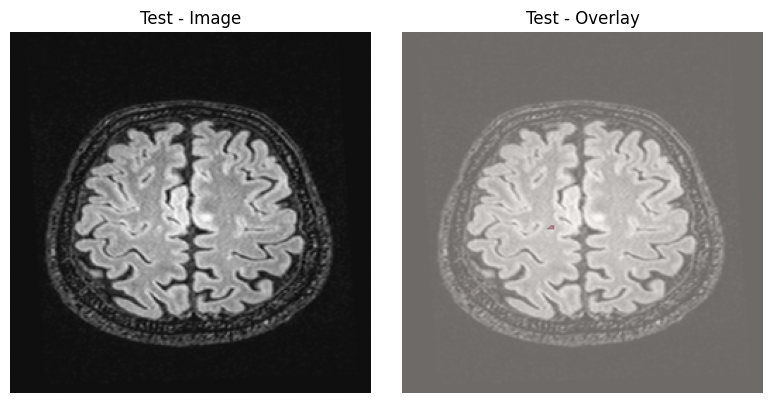

In [42]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Obtenir un index aléatoire pour chaque dataset
train_idx = np.random.randint(len(train_dataset))
val_idx = np.random.randint(len(val_dataset))
test_idx = np.random.randint(len(test_dataset))

print("train_idx:", train_idx)
print("val_idx:", val_idx)
print("test_idx:", test_idx)

def plot_slice(dataset, index, dataset_name):
    batch_data = dataset[index]
    image, label = batch_data[0].to(device), batch_data[1].to(device)

    # Conversion en numpy
    image = image.squeeze().detach().cpu().numpy()
    label = label.squeeze().detach().cpu().numpy()

    image = (image + 1) / 2.0  # Normaliser [0,1]

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    axes[0].imshow(image, cmap='gray')
    axes[0].set_title(f"{dataset_name} - Image")
    axes[0].axis('off')

    axes[1].imshow(image, cmap='gray')
    axes[1].imshow(label, cmap='Reds', alpha=0.4)
    axes[1].set_title(f"{dataset_name} - Overlay")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

# 🔥 Afficher séparément
#plot_slice(train_dataset, train_idx, dataset_name="Training")
#plot_slice(val_dataset, val_idx, dataset_name="Validation")
plot_slice(test_dataset, test_idx, dataset_name="Test")


## UNet Network Architecture

#### UNet params

In [43]:
# Model Architecture Parameters
input_channels = 1
num_classes  = 1      #  e.g. 1 for binary segmentation (background vs object)
input_shape = (input_channels, width, height)  # This is the shape of the input image to the network
output_shape = (num_classes, width, height)  # This is the shape of the output mask
init_channels = 32              # This is the number of channels in the first layer of the network
model_weights_path = "delete_exces_empty_mask_slice.pth"

#### The UNet model 

In [11]:
from monai.networks.nets import UNet

# Define a Unet with  monai, lighter than Class Unet 
# Creation of the model U-Net with MONAI
model = UNet(
    spatial_dims = 2,                   # 2D U-Net
    in_channels = 1,                    # e.g. 3 for RGB, 1 for grayscale input images
    out_channels = 1,                   # 1 for binary segmentation
    channels = (16, 32, 64, 128, 256),  # Nombres de canaux aux différents niveaux d'encodage
    strides = (2, 2, 2, 2),             # Strides de downsampling (modèle aura 4 niveaux) 
    num_res_units=1                     # Nombre d'unités résiduelles par bloc
).to(device)


#### Loss functions

In [12]:
# Option 1 : Utiliser Dice Loss seule => pas tres performant
# criterion = DiceLoss(sigmoid=True)

# Option 2 (recommandée) : Combiner Dice + BCE
class ComboLoss(nn.Module):
    def __init__(self, dice_weight=0.7):
        super().__init__()
        self.dice = DiceLoss(sigmoid=True)
        self.bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([20.0]).to(device))  # 20 peut être ajusté
        self.dice_weight = dice_weight

    def forward(self, inputs, targets):
        dice_loss = self.dice(inputs, targets)
        bce_loss = self.bce(inputs, targets)
        return self.dice_weight * dice_loss + (1 - self.dice_weight) * bce_loss

criterion = ComboLoss(dice_weight=0.7)

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

### Function to train the model

In [51]:
def train_model(model, train_dataloader, val_dataloader, optimizer, criterion, device, n_epochs, min_epoch=10):
    import torch
    from tqdm import tqdm

    model = model.to(device)
    train_losses = []
    valid_losses = []

    best_diff = float('inf')
    best_model_state = None
    best_epoch = 0

    for epoch in range(n_epochs):
        model.train()
        train_loss = 0.0

        for batch_data in tqdm(train_dataloader, desc=f"Epoch {epoch+1} - Training", leave=False):
            images, labels = batch_data[0].to(device), batch_data[1].to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)

        train_loss /= len(train_dataloader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for batch_data in tqdm(val_dataloader, desc=f"Epoch {epoch+1} - Validation", leave=False):
                val_inputs, val_labels = batch_data[0].to(device), batch_data[1].to(device)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                valid_loss += val_loss.item() * val_inputs.size(0)

        valid_loss /= len(val_dataloader.dataset)
        valid_losses.append(valid_loss)

        diff = abs(valid_loss - train_loss)
        print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {valid_loss:.4f} | Diff: {diff:.4f}")

        # Cherche le minimum de différence à partir de min_epoch
        if epoch + 1 >= min_epoch and diff < best_diff:
            best_diff = diff
            best_model_state = model.state_dict()
            best_epoch = epoch + 1

    print(f"\n✅ Best model selected at epoch {best_epoch} (after epoch {min_epoch}) with |Train - Val| loss diff: {best_diff:.4f}")
    
    return best_model_state, train_losses, valid_losses, best_epoch


### We save the model

In [14]:
def SaveModel(best_model, model_path, best_epoch):
    model.load_state_dict(best_model)
    torch.save(best_model, model_path)
    print(f"Best model selected at epoch {best_epoch} with validation loss: {best_valid_loss:.4f}")

def SaveTrainAndValidLosses(csv_path):
    loss_df = pd.DataFrame({
        'epoch': list(range(1, len(train_losses) + 1)),
        'train_loss': train_losses,
        'valid_loss': valid_losses
    })
    loss_df.to_csv(csv_path, index=False)
    print(f"📁 Losses saved to '{csv_path}'")

### Train and Save

In [56]:
best_model_state, train_losses, valid_losses, best_epoch = train_model(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    n_epochs=n_epochs,
    min_epoch=35
)

SaveModel(best_model_state, model_weights_path, best_epoch)


Epoch 1/60 | Train Loss: 0.1476 | Val Loss: 0.4204 | Diff: 0.2728


Epoch 2/60 | Train Loss: 0.1481 | Val Loss: 0.4238 | Diff: 0.2757


Epoch 3/60 | Train Loss: 0.1469 | Val Loss: 0.4205 | Diff: 0.2736


Epoch 4/60 | Train Loss: 0.1480 | Val Loss: 0.4193 | Diff: 0.2713


Epoch 5/60 | Train Loss: 0.1471 | Val Loss: 0.4120 | Diff: 0.2649


Epoch 6/60 | Train Loss: 0.1496 | Val Loss: 0.4167 | Diff: 0.2671


Epoch 7/60 | Train Loss: 0.1491 | Val Loss: 0.4122 | Diff: 0.2631


Epoch 8/60 | Train Loss: 0.1485 | Val Loss: 0.4240 | Diff: 0.2755


Epoch 9/60 | Train Loss: 0.1477 | Val Loss: 0.4161 | Diff: 0.2684


Epoch 10/60 | Train Loss: 0.1467 | Val Loss: 0.4220 | Diff: 0.2753


Epoch 11/60 | Train Loss: 0.1471 | Val Loss: 0.4239 | Diff: 0.2767


Epoch 12/60 | Train Loss: 0.1463 | Val Loss: 0.4202 | Diff: 0.2739


Epoch 13/60 | Train Loss: 0.1455 | Val Loss: 0.4296 | Diff: 0.2841


Epoch 14/60 | Train Loss: 0.1458 | Val Loss: 0.4386 | Diff: 0.2928


Epoch 15/60 | Train Loss: 0.1470 | Val Loss: 0.4337 | Diff: 0.2867


Epoch 16/60 | Train Loss: 0.1467 | Val Loss: 0.4292 | Diff: 0.2825


Epoch 17/60 | Train Loss: 0.1467 | Val Loss: 0.4372 | Diff: 0.2904


Epoch 18/60 | Train Loss: 0.1450 | Val Loss: 0.4334 | Diff: 0.2883


Epoch 19/60 | Train Loss: 0.1449 | Val Loss: 0.4333 | Diff: 0.2884


Epoch 20/60 | Train Loss: 0.1447 | Val Loss: 0.4295 | Diff: 0.2848


Epoch 21/60 | Train Loss: 0.1436 | Val Loss: 0.4410 | Diff: 0.2974


Epoch 22/60 | Train Loss: 0.1414 | Val Loss: 0.4349 | Diff: 0.2935


Epoch 23/60 | Train Loss: 0.1433 | Val Loss: 0.4296 | Diff: 0.2862


Epoch 24/60 | Train Loss: 0.1462 | Val Loss: 0.4377 | Diff: 0.2915


Epoch 25/60 | Train Loss: 0.1490 | Val Loss: 0.4454 | Diff: 0.2964


Epoch 26/60 | Train Loss: 0.1487 | Val Loss: 0.4290 | Diff: 0.2803


Epoch 27/60 | Train Loss: 0.1479 | Val Loss: 0.4432 | Diff: 0.2953


Epoch 28/60 | Train Loss: 0.1472 | Val Loss: 0.4632 | Diff: 0.3161


Epoch 29/60 | Train Loss: 0.1482 | Val Loss: 0.4303 | Diff: 0.2820


Epoch 30/60 | Train Loss: 0.1453 | Val Loss: 0.4323 | Diff: 0.2870


Epoch 31/60 | Train Loss: 0.1452 | Val Loss: 0.4369 | Diff: 0.2917


Epoch 32/60 | Train Loss: 0.1439 | Val Loss: 0.4504 | Diff: 0.3065


Epoch 33/60 | Train Loss: 0.1425 | Val Loss: 0.4310 | Diff: 0.2885


Epoch 34/60 | Train Loss: 0.1433 | Val Loss: 0.4428 | Diff: 0.2994


Epoch 35/60 | Train Loss: 0.1417 | Val Loss: 0.4520 | Diff: 0.3103


Epoch 36/60 | Train Loss: 0.1406 | Val Loss: 0.4396 | Diff: 0.2990


Epoch 37/60 | Train Loss: 0.1391 | Val Loss: 0.4448 | Diff: 0.3057


Epoch 38/60 | Train Loss: 0.1386 | Val Loss: 0.4351 | Diff: 0.2964


Epoch 39/60 | Train Loss: 0.1429 | Val Loss: 0.4555 | Diff: 0.3126


Epoch 40/60 | Train Loss: 0.1458 | Val Loss: 0.4447 | Diff: 0.2989


Epoch 41/60 | Train Loss: 0.1434 | Val Loss: 0.4379 | Diff: 0.2945


Epoch 42/60 | Train Loss: 0.1416 | Val Loss: 0.4609 | Diff: 0.3193


Epoch 43/60 | Train Loss: 0.1405 | Val Loss: 0.4461 | Diff: 0.3056


Epoch 44/60 | Train Loss: 0.1398 | Val Loss: 0.4476 | Diff: 0.3078


Epoch 45/60 | Train Loss: 0.1396 | Val Loss: 0.4423 | Diff: 0.3027


Epoch 46/60 | Train Loss: 0.1380 | Val Loss: 0.4567 | Diff: 0.3187


Epoch 47/60 | Train Loss: 0.1400 | Val Loss: 0.4563 | Diff: 0.3164


Epoch 48/60 | Train Loss: 0.1403 | Val Loss: 0.4443 | Diff: 0.3039


Epoch 49/60 | Train Loss: 0.1391 | Val Loss: 0.4558 | Diff: 0.3167


Epoch 50/60 | Train Loss: 0.1394 | Val Loss: 0.4630 | Diff: 0.3236


Epoch 51/60 | Train Loss: 0.1385 | Val Loss: 0.4706 | Diff: 0.3320


Epoch 52/60 | Train Loss: 0.1391 | Val Loss: 0.4615 | Diff: 0.3224


Epoch 53/60 | Train Loss: 0.1385 | Val Loss: 0.4493 | Diff: 0.3108


Epoch 54/60 | Train Loss: 0.1367 | Val Loss: 0.4538 | Diff: 0.3171


Epoch 55/60 | Train Loss: 0.1371 | Val Loss: 0.4534 | Diff: 0.3162


Epoch 56/60 | Train Loss: 0.1385 | Val Loss: 0.4546 | Diff: 0.3161


Epoch 57/60 | Train Loss: 0.1427 | Val Loss: 0.4568 | Diff: 0.3142


Epoch 58/60 | Train Loss: 0.1389 | Val Loss: 0.4626 | Diff: 0.3236


Epoch 59/60 | Train Loss: 0.1372 | Val Loss: 0.4406 | Diff: 0.3033


Epoch 60/60 | Train Loss: 0.1347 | Val Loss: 0.4551 | Diff: 0.3204

✅ Best model selected at epoch 41 (after epoch 35) with |Train - Val| loss diff: 0.2945


NameError: name 'best_valid_loss' is not defined

### Display Train Curves 

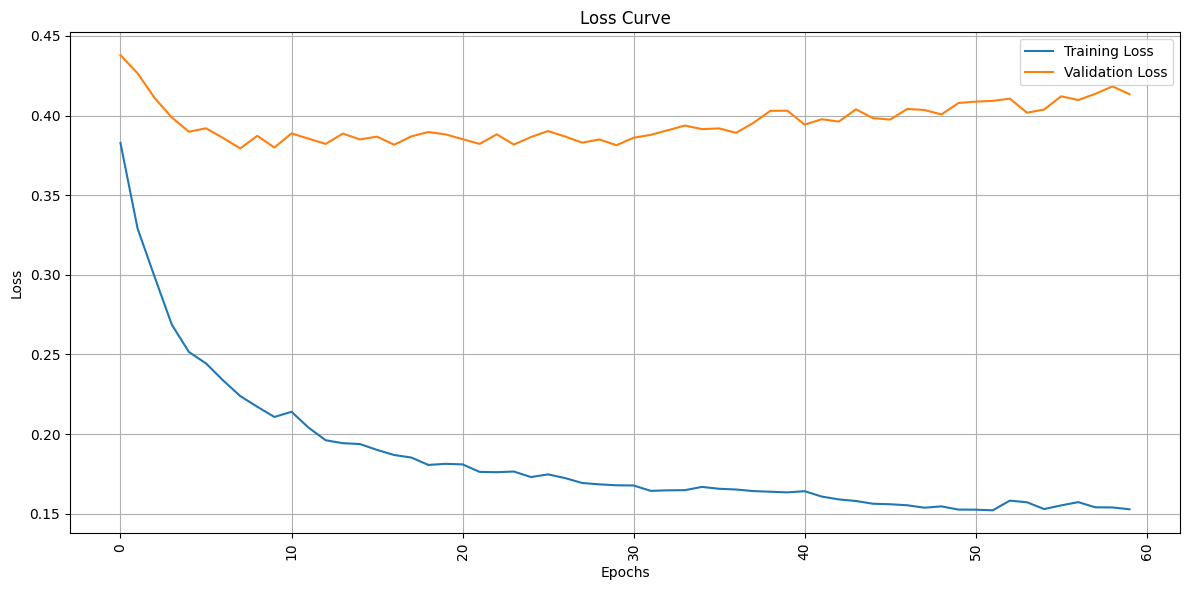

In [46]:
# Save data
# SaveTrainAndValidLosses("train_and_losses_500_epochs.csv")


plt.figure(figsize=(12, 6))  # plot plus large

# Tracer les courbes
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')

plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Grille activée
plt.grid(True)

# Ticks tous les 10 epochs
num_epochs = len(train_losses)
plt.xticks(range(0, num_epochs + 1, 10), rotation=90)  # valeurs horizontales

plt.tight_layout()  # évite que le texte soit coupé
plt.show()


## Load and test the "best" model

In [47]:
model.load_state_dict(torch.load(model_weights_path))

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


<All keys matched successfully>

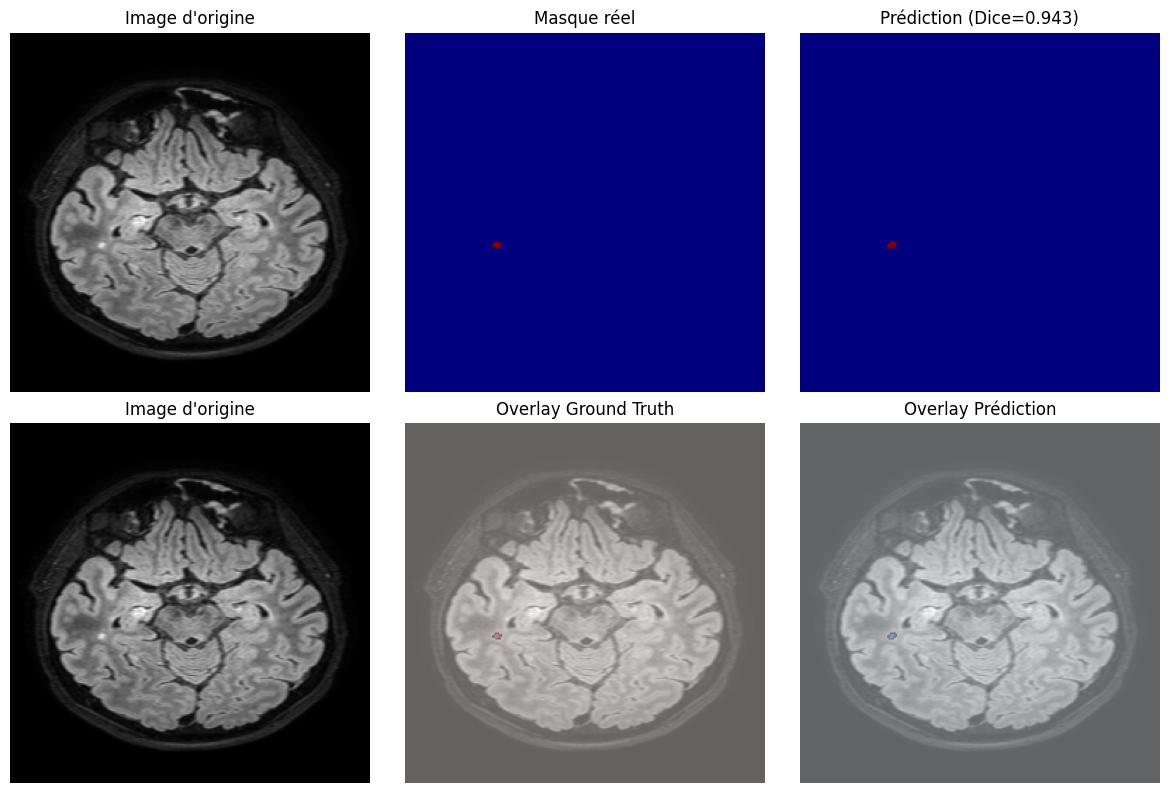

✅ Résultats globaux sur le test set :
Dice (MONAI) : 0.4524
IoU  (MONAI) : 0.3432
Dice (NumPy) : 0.3868
IoU  (NumPy) : 0.2934
📸 Meilleure image (Dice NumPy) : 0.9434


In [48]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from monai.networks.nets import UNet
from sklearn.metrics import jaccard_score
from monai.metrics import DiceMetric, MeanIoU

# --- METRICS MONAI ---
dice_metric = DiceMetric(include_background=False, reduction="mean")
iou_metric = MeanIoU(include_background=False)

# --- METRICS numpy ---
def dice_score(pred, label):
    pred = pred.astype(np.bool_)
    label = label.astype(np.bool_)
    intersection = np.logical_and(pred, label).sum()
    return 2. * intersection / (pred.sum() + label.sum() + 1e-8)

def iou_score(pred, label):
    pred = pred.astype(np.bool_)
    label = label.astype(np.bool_)
    intersection = np.logical_and(pred, label).sum()
    union = np.logical_or(pred, label).sum()
    return intersection / (union + 1e-8)

# --- FONCTION D'ÉVALUATION ---
def evaluate_model_with_best_visual(model, dataloader, device):
    model = model.to(device)
    model.eval()

    # Réinitialiser les métriques MONAI
    dice_metric = DiceMetric(include_background=False, reduction="mean")
    iou_metric = MeanIoU(include_background=False)
    dice_metric.reset()
    iou_metric.reset()

    # Listes pour stocker toutes les métriques NumPy
    all_dice = []
    all_iou = []

    # Variables pour suivre la meilleure prédiction
    best_dice = -1
    best_img = None
    best_lbl = None
    best_pred = None

    with torch.no_grad():
        for images, labels, names in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            preds = torch.sigmoid(model(images))
            preds = (preds > 0.5).float()

            # MONAI batch update
            dice_metric(preds, labels)
            iou_metric(preds, labels)

            # Loop par image pour NumPy + meilleure image
            for i in range(images.size(0)):
                img = images[i].squeeze().cpu().numpy()
                lbl = labels[i].squeeze().cpu().numpy()
                prd = preds[i].squeeze().cpu().numpy()
                
                img = (img + 1) / 2.0  # [-1, 1] -> [0, 1]

                d = dice_score(prd, lbl)
                j = iou_score(prd, lbl)

                all_dice.append(d)
                all_iou.append(j)

                if d > best_dice:
                    best_dice = d
                    best_img = img
                    best_lbl = lbl
                    best_pred = prd

    # === Affichage d'une seule image : meilleure Dice ===
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))

    axes[0, 0].imshow(best_img, cmap="gray")
    axes[0, 0].set_title("Image d'origine")
    axes[0, 0].axis("off")

    axes[0, 1].imshow(best_lbl, cmap="jet")
    axes[0, 1].set_title("Masque réel")
    axes[0, 1].axis("off")

    axes[0, 2].imshow(best_pred, cmap="jet")
    axes[0, 2].set_title(f"Prédiction (Dice={best_dice:.3f})")
    axes[0, 2].axis("off")

    axes[1, 0].imshow(best_img, cmap="gray")
    axes[1, 0].set_title("Image d'origine")
    axes[1, 0].axis("off")

    axes[1, 1].imshow(best_img, cmap="gray")
    axes[1, 1].imshow(best_lbl, cmap="Reds", alpha=0.4)
    axes[1, 1].set_title("Overlay Ground Truth")
    axes[1, 1].axis("off")

    axes[1, 2].imshow(best_img, cmap="gray")
    axes[1, 2].imshow(best_pred, cmap="Blues", alpha=0.4)
    axes[1, 2].set_title("Overlay Prédiction")
    axes[1, 2].axis("off")

    plt.tight_layout()
    plt.show()

    # === Affichage global des performances ===
    print("✅ Résultats globaux sur le test set :")
    print(f"Dice (MONAI) : {dice_metric.aggregate().item():.4f}")
    print(f"IoU  (MONAI) : {iou_metric.aggregate().item():.4f}")
    print(f"Dice (NumPy) : {np.mean(all_dice):.4f}")
    print(f"IoU  (NumPy) : {np.mean(all_iou):.4f}")
    print(f"📸 Meilleure image (Dice NumPy) : {best_dice:.4f}")



# --- UTILISATION ---
# Exemple :
# model = UNet(...)  # Ton modèle déjà chargé
# test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=1)

evaluate_model_with_best_visual(model, test_dataloader, device)


In [54]:
from collections import defaultdict

def evaluate_model_per_patient(model, dataloader, device):
    model = model.to(device)
    model.eval()

    # Stockage des scores par patient
    scores_per_patient = defaultdict(list)

    with torch.no_grad():
        for images, labels, names in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            preds = torch.sigmoid(model(images))
            preds = (preds > 0.5).float()

            for i in range(images.size(0)):
                img = images[i].squeeze().cpu().numpy()
                lbl = labels[i].squeeze().cpu().numpy()
                prd = preds[i].squeeze().cpu().numpy()
                if lbl.sum() == 0:
                    continue
                name = names[i]
                
                # Extraire le nom du patient (ex: "01016SACH_slice_001.png" -> "01016SACH")
                patient_id = name.split("_")[0]

                d = dice_score(prd, lbl)
                scores_per_patient[patient_id].append((int(name.split("_")[-1].split(".")[0]), d))  # (slice_idx, dice)

    # Affichage des courbes de Dice par slice
    for patient, slice_scores in sorted(scores_per_patient.items()):
        slice_scores.sort()  # trier par index de slice
        slice_ids = [s[0] for s in slice_scores]
        dice_vals = [s[1] for s in slice_scores]

        plt.figure(figsize=(10, 4))
        plt.plot(slice_ids, dice_vals, marker='o')
        plt.title(f"Dice par slice pour le patient {patient}")
        plt.xlabel("Indice de la slice")
        plt.ylabel("Dice score")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
      
        print(f"📊 Moyenne Dice pour {patient} : {np.mean(dice_vals):.4f}")


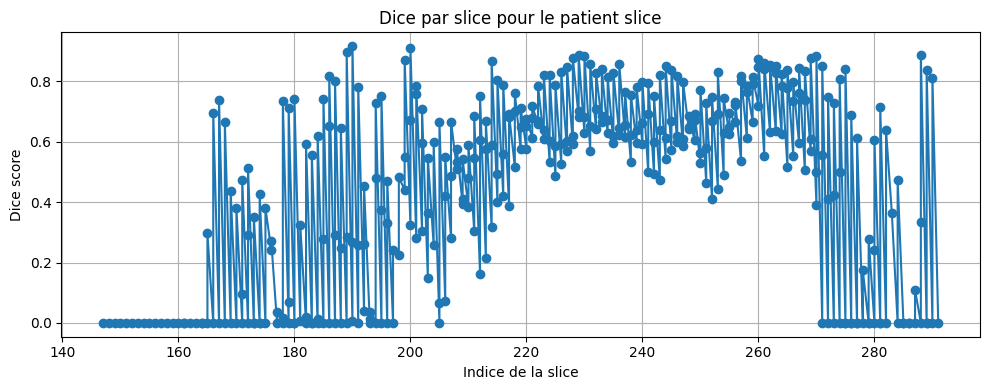

📊 Moyenne Dice pour slice : 0.4620


In [55]:
evaluate_model_per_patient(model, test_dataloader, device)
